## EDA Clustering Exercises 

In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from sklearn.model_selection import learning_curve

import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

from importlib import reload
import wrangle_zillow as wz

pd.options.display.float_format = '{:,.3f}'.format

In [76]:
from sklearn.preprocessing import scale

In [4]:
import wrangle as wr

In [70]:
# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [136]:
train, _, _ = wr.split_zillow(wr.get_zillow2())

In [137]:
# create a sample for some visualizations
sample = train.sample(frac = 0.05)

In [138]:
# set the alpha level 0.05 for statistical tests
α = 0.05

In [139]:
numerical_columns = train.iloc[:, :8].columns.tolist()
categorical_columns = train.iloc[:, 11:-1].columns.tolist()
# for the exploration I will use the absolute value of the log error
target = np.abs(sample.logerror)

##### numerical_columns
'sqft', 'garage_sqft', 'lot_sqft', 'age', 'structure_price', 'price', 'land_price', 'tax_amount'

##### categorical_columns
'bath', 'beds', 'fireplace', 'garage', 'hottub_spa', 'pool', 'unit', 'heating_system', 'county_land_code', 'county_name'

In [157]:
logerror_bins = pd.cut(sample.logerror, bins=[-0.5, -0.3, -0.15, 0, 0.15, 0.3, 0.55])

In [158]:
sample['log_bins'] = logerror_bins
sample['abs_logerror'] = target

In [214]:
sample['log_bins4'] = pd.cut(sample.logerror, bins=[-0.5, -0.25, 0, 0.25, 0.5])

In [145]:
# create a logarithmic columns for numerical values ['sqft','garage_sqft','lot_sqft','age','structure_price',
# 'price', 'land_price', 'tax_amount']

# the point is... the logerror is a log value of MSE (looks like it is scaled as well with the standard scaler)
log_cols = []
for col in numerical_columns:
    name = 'log_' + col
    log_cols.append(name)
    sample[name] = np.log(sample[col])

In [146]:
sample.columns

Index(['sqft', 'garage_sqft', 'lot_sqft', 'age', 'structure_price', 'price',
       'land_price', 'tax_amount', 'zip', 'latitude', 'longitude', 'bath',
       'beds', 'fireplace', 'garage', 'hottub_spa', 'pool', 'unit',
       'heating_system', 'county_land_code', 'county_name', 'logerror',
       'log_bins', 'abs_logerror', 'log_sqft', 'log_garage_sqft',
       'log_lot_sqft', 'log_age', 'log_structure_price', 'log_price',
       'log_land_price', 'log_tax_amount'],
      dtype='object')

#### 1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

1. Does the ```logerror``` differ in 3 different counties?
2. How the ```age``` of the house relates to the ```logerror```?
3. Is the square footage related to the ```logerror```?

#### 2. Answer those questions through a mix of statistical tests and visualizations.

##### Question 1. Does the ```logerror``` differ in 3 different counties?*

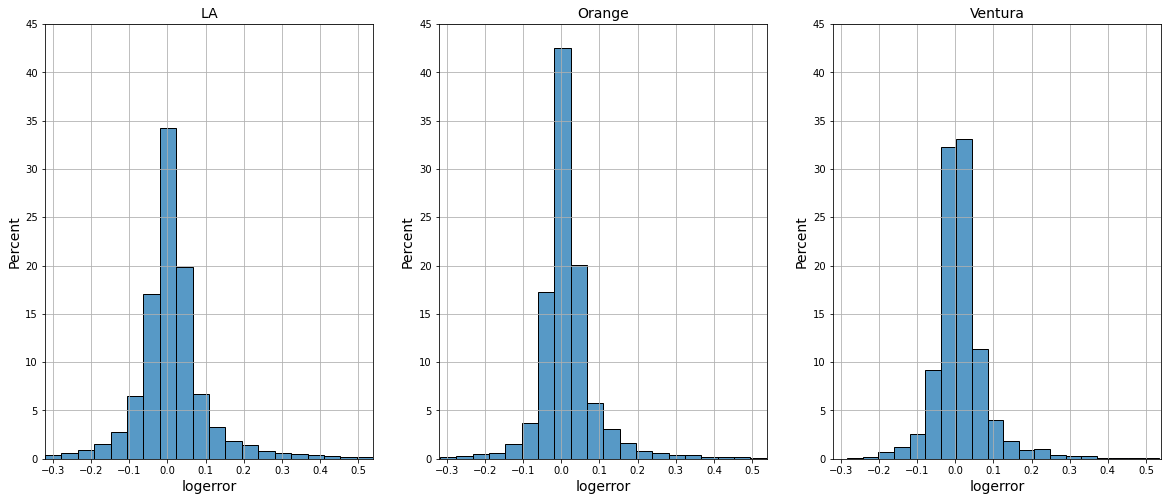

In [84]:
plt.figure(figsize=(20, 8))
for i, col in zip(range(1, 4), train.county_name.unique().tolist()):
    data = train[train['county_name'] == col]
    plt.subplot(1, 3, i)
    #data.logerror.hist(bins=10)
    sns.histplot(data=data, x='logerror', stat='percent', bins=20)
    plt.xlim(train.logerror.min(), train.logerror.max())
    plt.grid(True)
    plt.ylim(0, 45)
    plt.title(col)

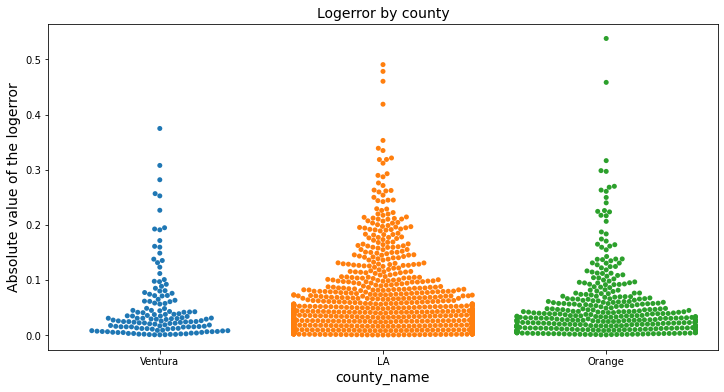

In [102]:
plt.figure(figsize=(12, 6))
plt.title('Logerror by county')
sns.swarmplot(x=sample['county_name'], y=target)
plt.ylabel('Absolute value of the logerror');

Looks that the ```logerror``` is spread in all 3 counties, but Orange county has the highest percentage of the no-error predictions.

Let's run the ANOVA statistical test to find out if there is a significal difference in the logerror among the counties.

In [91]:
f, p = stats.f_oneway(train[train['county_name'] == 'LA'].logerror, 
               train[train['county_name'] == 'Orange'].logerror, 
               train[train['county_name'] == 'Ventura'].logerror)
print(f'F: {round(f, 2)}, p: {round(p, 2)}')

F: 3.82, p: 0.02


The p-value is lower that our significance level. It means that there is a difference in logerrors among different counties.

##### *2. *How the ```age``` of the house relates to the ```logerror```?*

In [149]:
sample.columns

Index(['sqft', 'garage_sqft', 'lot_sqft', 'age', 'structure_price', 'price',
       'land_price', 'tax_amount', 'zip', 'latitude', 'longitude', 'bath',
       'beds', 'fireplace', 'garage', 'hottub_spa', 'pool', 'unit',
       'heating_system', 'county_land_code', 'county_name', 'logerror',
       'log_bins', 'abs_logerror', 'log_sqft', 'log_garage_sqft',
       'log_lot_sqft', 'log_age', 'log_structure_price', 'log_price',
       'log_land_price', 'log_tax_amount'],
      dtype='object')

In [162]:
logerror_bins.unique().tolist()

[Interval(-0.15, 0.0, closed='right'),
 Interval(0.0, 0.15, closed='right'),
 Interval(0.3, 0.55, closed='right'),
 Interval(0.15, 0.3, closed='right'),
 Interval(-0.5, -0.3, closed='right'),
 Interval(-0.3, -0.15, closed='right')]

In [164]:
sample.age.min(), sample.age.max()

(2, 112)

In [186]:
sample['age_bins'] = pd.cut(sample.age, bins=[0, 20, 40, 60, 80, 100, 120])

In [189]:
age_bins = []
for i in range(6):
    age_bins.append(str(sample.age_bins.value_counts().reset_index().sort_values(by='index').iloc[i, 0]))

In [190]:
age_bins

['(0, 20]', '(20, 40]', '(40, 60]', '(60, 80]', '(80, 100]', '(100, 120]']

In [197]:
sample.age_bins = sample.age_bins.astype(str)

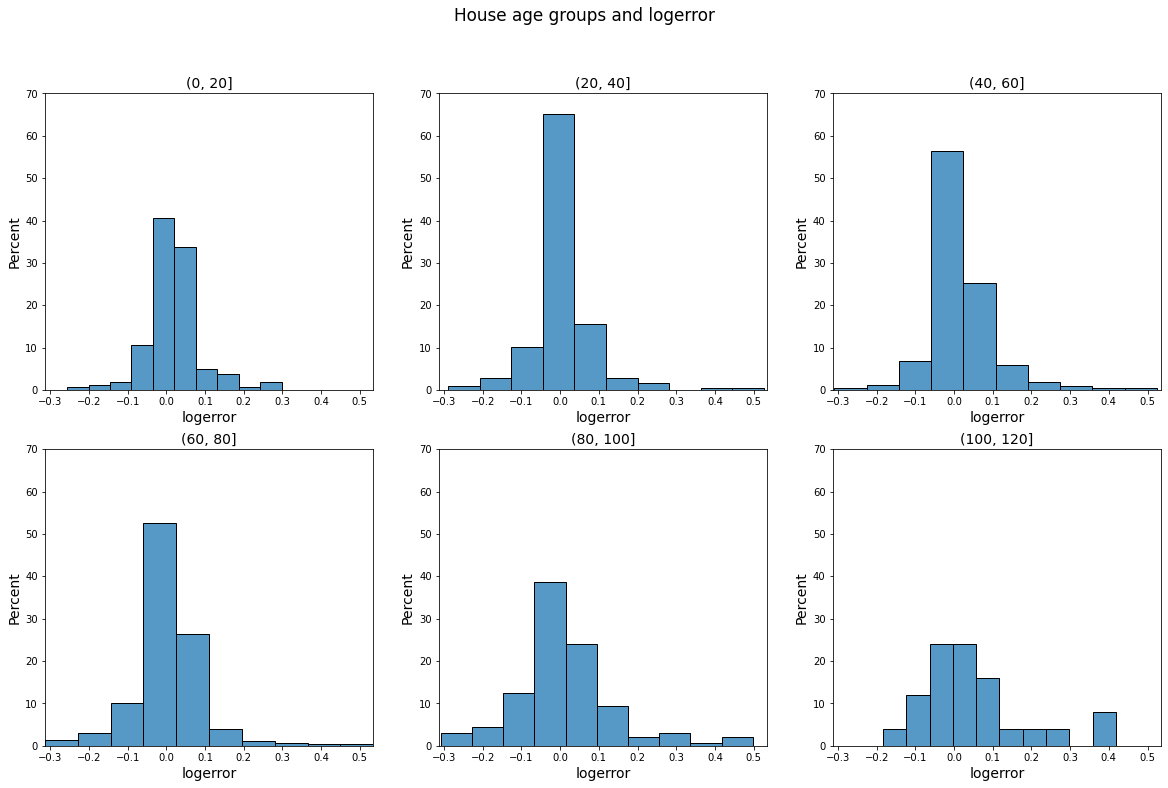

In [208]:
plt.figure(figsize=(20, 12))
plt.suptitle('House age groups and logerror')
for i, age in enumerate(age_bins):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=sample[sample.age_bins==age], x='logerror', stat='percent', bins=10)
    plt.title(age)
    plt.xlim(sample.logerror.min(), sample.logerror.max())
    plt.ylim(0, 70)

We can see that the houses that are 20-40 years old have the best predictions, while houses after the age of 80 years have a big spread of ```logerror``` and their price is harder to predict

##### *3. Is the square footage related to the ```logerror```?*

In [ ]:
sns.scatterplot(data=sample, )

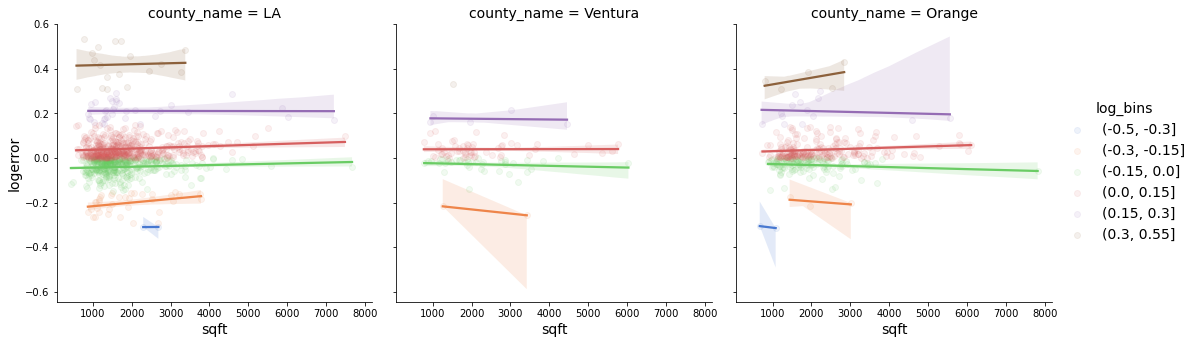

In [216]:
sns.lmplot(x='sqft', y='logerror', data=sample, 
           palette='muted', col='county_name', hue='log_bins',
           scatter_kws = {'alpha' : 0.09} );

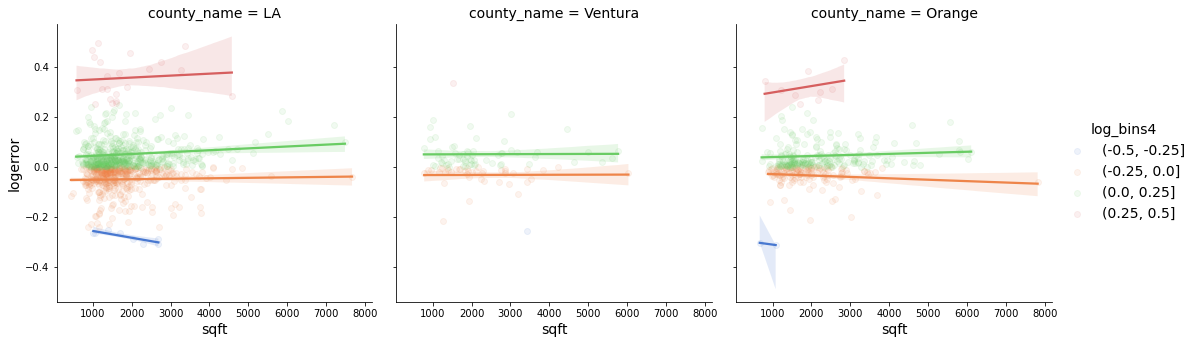

In [215]:
sns.lmplot(x='sqft', y='logerror', data=sample, 
           palette='muted', col='county_name', hue='log_bins4',
           scatter_kws = {'alpha' : 0.09} );

We can clearly see in Ventura county ```sqft``` are not related to ```logerror```.
Squared footage and ```logerror``` seems not to be related at all. I need to confirm it with the statistical test. I'm going to use Pearson R test to check if there is a the correlation  between these two variables.

In [225]:
corr, p = stats.pearsonr(train.sqft, train.logerror)
print(f'Correlation coefficient is {round(corr, 3)}')
print(f'P-value is {round(p, 2)}')

Correlation coefficient is 0.062
P-value is 0.0


Even the correlation coefficient is very low, p-value points that there is a relationship between square footage and ```logerror```.

In [73]:
location = sample[['latitude', 'longitude']].copy()

In [78]:
location=pd.DataFrame(scale(location), columns = ['latitude', 'longitude'])

In [79]:
location

,latitude,longitude
0,0.582,0.336
1,0.073,0.660
2,0.428,-0.054
3,0.534,0.231
4,-0.526,-0.554
...,...,...
561,-0.803,-0.707
562,-1.166,0.611
563,-1.162,0.530
564,2.109,0.070


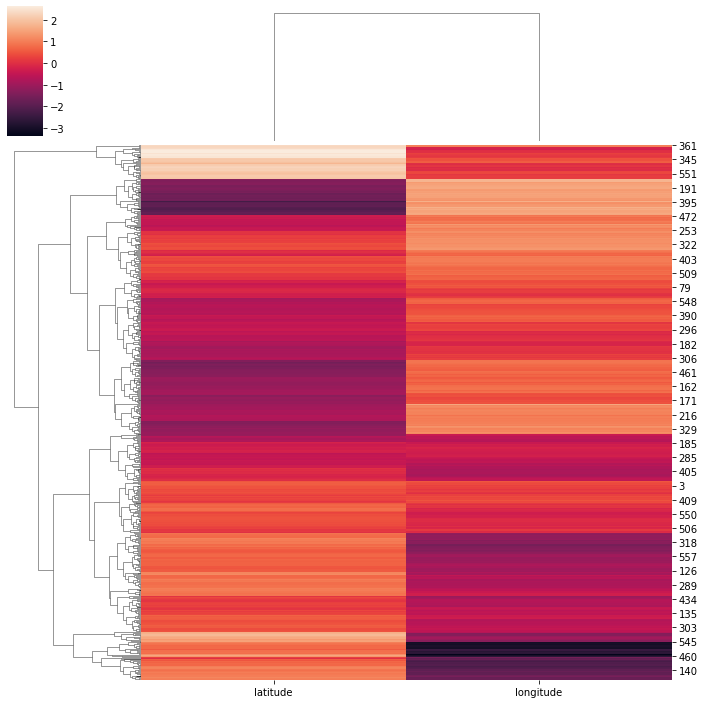

In [80]:
sns.clustermap(location)

In [123]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1416 entries, 36348 to 46500
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   sqft              1416 non-null   int64   
 1   garage_sqft       1416 non-null   int64   
 2   lot_sqft          1416 non-null   int64   
 3   age               1416 non-null   int64   
 4   structure_price   1416 non-null   int64   
 5   price             1416 non-null   int64   
 6   land_price        1416 non-null   int64   
 7   tax_amount        1416 non-null   float64 
 8   zip               1416 non-null   int64   
 9   latitude          1416 non-null   int64   
 10  longitude         1416 non-null   int64   
 11  bath              1416 non-null   uint8   
 12  beds              1416 non-null   uint8   
 13  fireplace         1416 non-null   uint8   
 14  garage            1416 non-null   uint8   
 15  hottub_spa        1416 non-null   uint8   
 16  pool              1

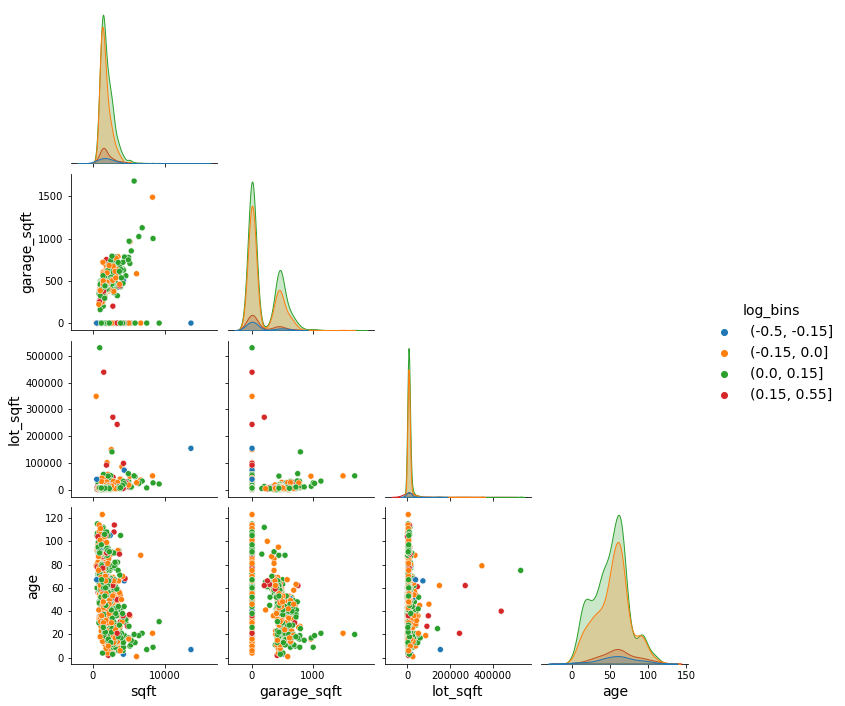

In [130]:

sns.pairplot(data=sample[['sqft','garage_sqft', 'lot_sqft', 'age', 'log_bins']], hue='log_bins', corner=True);